# **Pattern Recognition Assignment 3**

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

## Question 1

In [2]:
df = pd.read_csv('/content/drive/MyDrive/PR/gender_feature_vectors.csv')
df.head(3)

,Unnamed: 0,Unnamed: 1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,1,male,-0.066420,0.151611,0.027740,0.052771,-0.066105,-0.041232,-0.002637,-0.158467,0.130467,-0.044872,0.272529,-0.107907,-0.190014,-0.145586,-0.012682,0.154819,-0.241271,-0.162936,-0.120377,-0.047154,-0.004024,0.010867,0.013803,0.033862,-0.165088,-0.356740,-0.104970,-0.089917,0.163656,-0.138332,0.011188,0.005595,-0.144617,-0.070563,0.089040,0.042198,-0.013146,-0.088541,...,0.176488,0.023528,-0.042136,0.146026,-0.060144,-0.045779,0.005116,-0.040269,-0.146532,0.020204,-0.071422,-0.070934,0.039376,-0.073057,0.013110,0.073191,-0.174984,0.112673,0.050317,-0.087701,-0.033930,0.018559,-0.087492,0.076850,0.160139,-0.359518,0.225189,0.175419,-0.003953,0.142986,0.025989,-0.001087,0.027260,-0.046754,-0.118619,-0.163774,-0.000590,-0.076400,0.107497,0.001567
1,2,male,-0.030614,0.049667,0.008084,-0.050324,0.007649,-0.063818,-0.019530,-0.119905,0.186553,-0.044821,0.271853,-0.041583,-0.252784,-0.117582,-0.040385,0.112987,-0.199148,-0.059140,-0.138428,-0.128424,0.139366,0.032024,0.092371,0.043215,-0.143541,-0.271580,-0.007330,-0.176620,0.074239,-0.121689,0.007702,0.039026,-0.212572,-0.110950,0.037608,0.048441,-0.049306,-0.044366,...,0.068932,-0.057217,-0.111655,0.211533,-0.086261,0.087350,0.046462,0.012710,-0.140843,-0.009904,-0.077447,-0.016317,0.019141,-0.092818,0.007209,0.017404,-0.177952,0.121269,-0.034220,-0.007996,-0.047971,-0.019876,-0.088064,0.071553,0.130182,-0.311870,0.315533,0.231109,-0.002901,0.161646,0.044229,-0.023900,-0.028108,0.040618,-0.146579,-0.141244,0.016162,0.017638,0.080610,-0.015930
2,3,male,-0.096178,0.061127,0.035326,-0.035388,-0.090728,-0.018634,-0.024315,-0.139786,0.052211,-0.052085,0.248798,-0.023033,-0.284685,-0.207826,0.078375,0.110781,-0.099561,-0.159526,-0.156689,-0.046377,-0.066865,-0.016259,0.119524,-0.036528,-0.200072,-0.347999,-0.092376,-0.110221,0.003830,-0.072553,-0.037326,0.049584,-0.241518,-0.144820,0.016032,0.116784,-0.058099,-0.026928,...,0.139447,-0.073286,-0.028742,0.176206,0.000778,0.061516,0.151425,0.097024,-0.069615,-0.021548,-0.135799,0.083675,0.152181,-0.062115,0.024492,0.094129,-0.092504,0.125004,-0.017716,-0.031443,0.050664,-0.127573,-0.048483,-0.116371,0.103385,-0.245697,0.202906,0.183545,-0.075050,0.141646,0.111141,0.059436,-0.029222,0.042115,-0.222173,-0.116908,0.093428,0.017391,0.057652,0.086116


In [3]:
# Pre-process dataframe into numpy array

df1 = df.drop(['Unnamed: 0', 'Unnamed: 1'], axis = 1)
X = np.array(df1)

print(X.shape)

(800, 128)


In [4]:
# Function which returns the principal components of 95% variance, given the input features

def PCA(X):

    mean = np.average(X, axis = 0)

    # Covariance matrix
    Z = (X - mean) /  (np.max(X, axis = 0) - np.min(X, axis = 0))
    cov_mat = np.dot(Z.T, Z)

    # Eigen Values and vectors
    e_val, e_vec = np.linalg.eigh(cov_mat)
    print('Eigen value shape :', e_val.shape,'Eigen vector shape :', e_vec.shape)

    # Sort eigen values in descending order
    sorted_e_val = np.flip(np.sort(e_val))
    sorted_e_vec = e_vec.copy()
    dummy = 0

    # Re-arrange columns of eigen vectors accordingly
    for val in sorted_e_val:
        ind = np.argmax(e_val == val * 1)
        sorted_e_vec[:,dummy] = e_vec[:,ind]
        dummy +=1

    # Select PCs which contribute to 95% of the total variance
    e_val_sum = np.sum(sorted_e_val)
    thresh = e_val_sum * 0.95

    dummy_sum = 0
    d_dash = 0

    while dummy_sum < thresh:
        dummy_sum += sorted_e_val[d_dash]
        d_dash += 1

    print('New axis count :', d_dash)    

    plt.figure(figsize = (55, 13))
    plt.bar([str(i + 1) for i in range(d_dash)], (np.sort(e_val))[-d_dash:])
    plt.title('Eigen Values(E_V) of top Principal Components')
    plt.show()

    Z_star = np.dot(Z, sorted_e_vec)

    return Z_star[:,:d_dash]

Eigen value shape : (128,) Eigen vector shape : (128, 128)
New axis count : 57


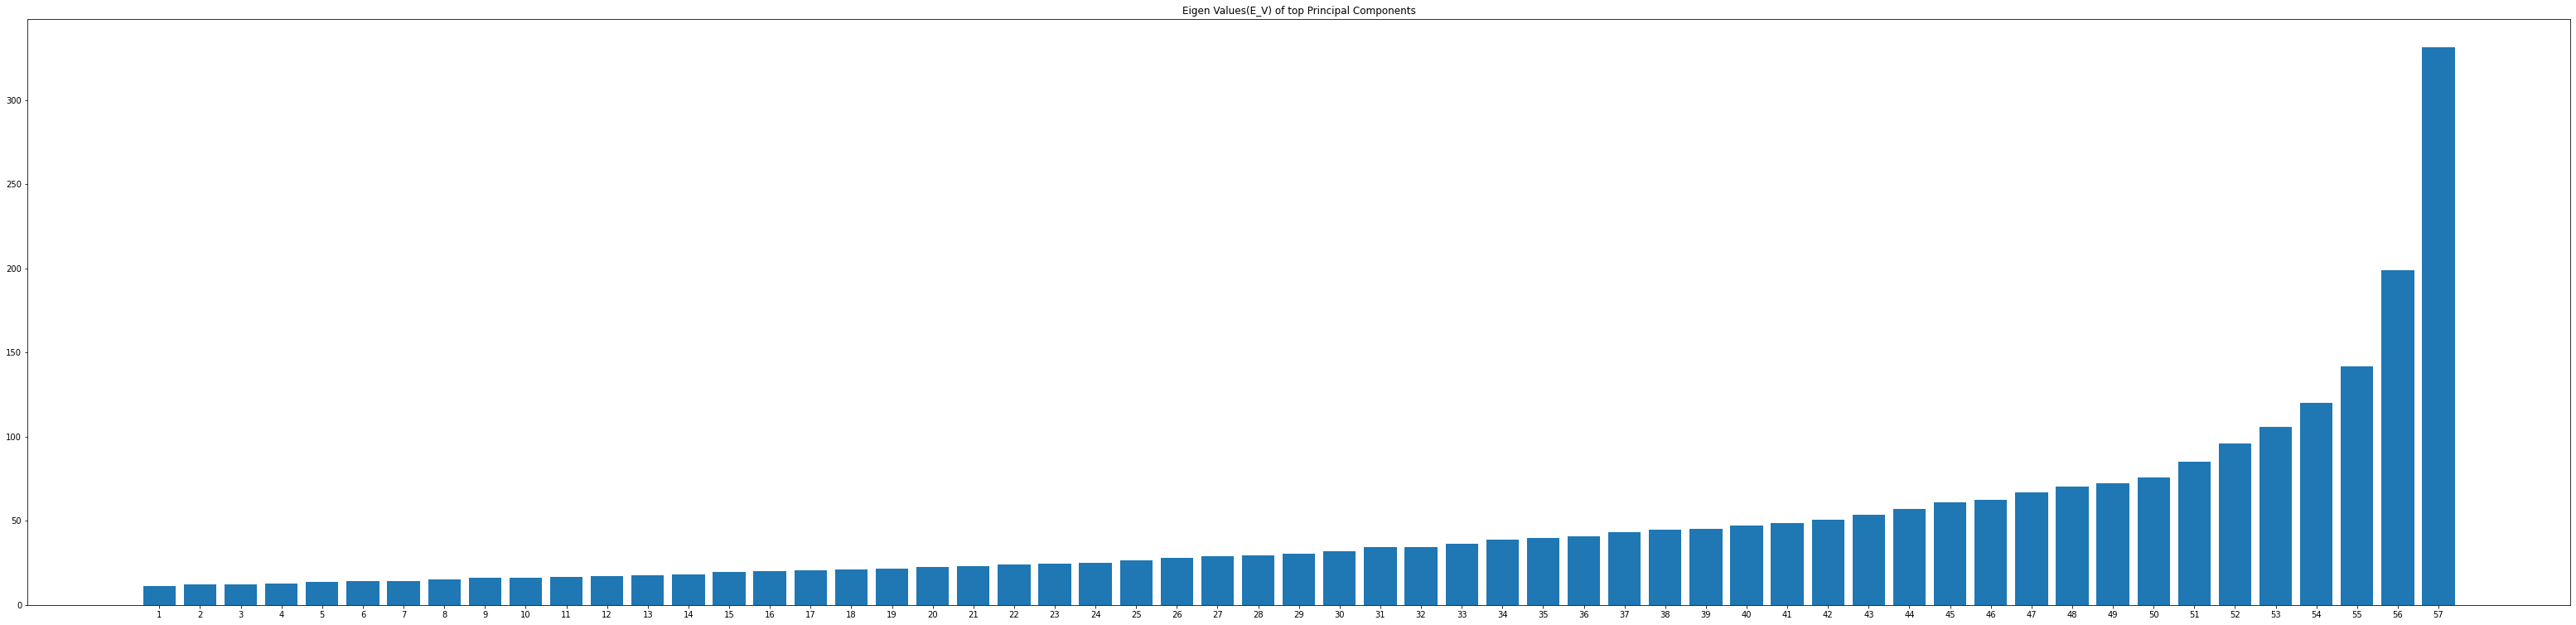

In [5]:
PC_X = PCA(X)

In [6]:
# Split into 2 classes (male and female)
class1 = PC_X[:len(df.loc[df['Unnamed: 1'] == 'male'])]
class2 = PC_X[len(df.loc[df['Unnamed: 1'] == 'male']):]

In [7]:
# Train - test split 
train1 = class1[10:]
test1 = class1[:10]

train2 = class2[10:]
test2 = class2[:10]

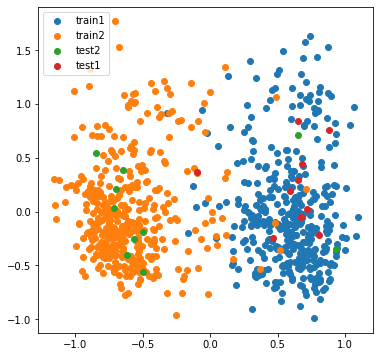

In [8]:
plt.figure(figsize= (6, 6))

plt.scatter(train1[:,0], train1[:,1])
plt.scatter(train2[:,0], train2[:,1])

plt.scatter(test2[:,0], test2[:,1])
plt.scatter(test1[:,0], test1[:,1])

plt.legend(['train1', 'train2', 'test2', 'test1'])
plt.show()

In [9]:
# square root of sum of square of distances

print('Predictions for the male test points:\n')

q1_pred_test1 = []

for samp in test1:

    q1_pred_test1.append(np.sqrt(np.sum(np.square(train1 - samp))) < np.sqrt(np.sum(np.square(train2 - samp))))
    print('The predition is', np.sqrt(np.sum(np.square(train1 - samp))) < np.sqrt(np.sum(np.square(train2 - samp))))

q1_pred_test1 = np.stack(q1_pred_test1) * 1

print('\n-------------------')
print('\nPredictions for the female test points:\n')

q1_pred_test2 = []

for samp in test2:
    
    q1_pred_test2.append(np.sqrt(np.sum(np.square(train1 - samp))) > np.sqrt(np.sum(np.square(train2 - samp))))
    print('The predition is', np.sqrt(np.sum(np.square(train1 - samp))) > np.sqrt(np.sum(np.square(train2 - samp))))

q1_pred_test2 = np.stack(q1_pred_test2) * 1

q1_indices_one = q1_pred_test2 == 1
q1_indices_zero = q1_pred_test2 == 0
q1_pred_test2[q1_indices_one] = 0
q1_pred_test2[q1_indices_zero] = 1


Predictions for the male test points:

The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is False
The predition is True
The predition is True

-------------------

Predictions for the female test points:

The predition is False
The predition is False
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True


----------------------------------------------------------------------------------------------------------------------------------------

## Question 2

In [10]:
class1 = X[:len(df.loc[df['Unnamed: 1'] == 'male'])]
class2 = X[len(df.loc[df['Unnamed: 1'] == 'male']):]

X0 = class1[10:]
test0 = class1[:10]

X1 = class2[10:]
test1 = class2[:10]

X0X1 = np.row_stack((X0, X1))

print('Input shape of class male :', X0.shape, '\nInput shape of class female :', X1.shape)

Input shape of class male : (389, 128) 
Input shape of class female : (391, 128)


In [11]:
def LDA(X0X1, X0, X1, d_dash):

    mean0 = np.average(X0, axis = 0)
    mean1 = np.average(X1, axis = 0)

    # Within class scatter matrix

    Sw = np.zeros((len(mean0), len(mean0)))

    for row in X0:
        subbed = (row - mean0).reshape((len(mean0), 1))
        dotted = np.dot(subbed, subbed.T)
        Sw += dotted    

    for row in X1:
        subbed = (row - mean1).reshape((len(mean1), 1))
        dotted = np.dot(subbed, subbed.T)
        Sw += dotted    


    # Between class scatter matrix

    Sb = np.zeros((len(mean0), len(mean0)))
    subbed = (mean0 - np.average(X0X1, axis = 0)).reshape((len(mean0), 1))
    Sb += len(X0) * np.dot(subbed, subbed.T)

    subbed = (mean1 - np.average(X0X1, axis = 0)).reshape((len(mean1), 1))
    Sb += len(X1) * np.dot(subbed, subbed.T)


    # Eigen Values and Vectors

    e_val, e_vec = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))

    sorted_e_val = np.flip(np.sort(e_val))
    sorted_e_vec = e_vec.copy()


    for dummy, val in enumerate(sorted_e_val):

        ind = np.argmax(e_val == val * 1)
        sorted_e_vec[:,dummy] = e_vec[:,ind]

    new_feat = np.dot(X0X1, sorted_e_vec)

    return new_feat[:,:d_dash], sorted_e_vec

In [12]:
LD_X, trans_mat = LDA(X0X1, X0, X1, 1)

In [13]:
class0 = LD_X[:389]
class1 = LD_X[389:]

In [14]:
test0 = np.dot(test0, trans_mat)[:,:1]
test1 = np.dot(test1, trans_mat)[:,:1]

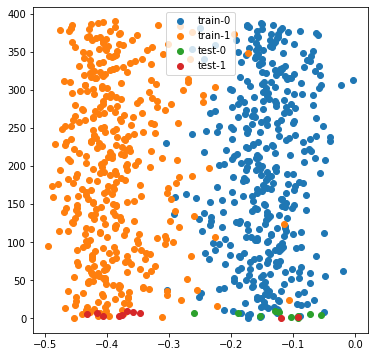

In [15]:
plt.figure(figsize= (6, 6))

plt.scatter(class0[:,0], range(len(class0[:,0])))
plt.scatter(class1[:,0], range(len(class1[:,0])))

plt.scatter(test0[:,0], range(len(test0[:,0])))
plt.scatter(test1[:,0], range(len(test1[:,0])))

plt.legend(['train-0', 'train-1', 'test-0', 'test-1'])
plt.show()

In [16]:
# square root of sum of square of distances

print('Predictions for the male test points:\n')

q2_pred_test1 = []

for samp in test0:

    q2_pred_test1.append(np.sqrt(np.sum(np.square(class0 - samp))) < np.sqrt(np.sum(np.square(class1 - samp))))
    print('The predition is', np.sqrt(np.sum(np.square(class0 - samp))) < np.sqrt(np.sum(np.square(class1 - samp))))

q2_pred_test1 = np.stack(q2_pred_test1) * 1

print('\n-------------------')
print('\nPredictions for the female test points:\n')

q2_pred_test2 = []

for samp in test1:
    
    q2_pred_test2.append(np.sqrt(np.sum(np.square(class0 - samp))) > np.sqrt(np.sum(np.square(class1 - samp))))
    print('The predition is', np.sqrt(np.sum(np.square(class0 - samp))) > np.sqrt(np.sum(np.square(class1 - samp))))

q2_pred_test2 = np.stack(q2_pred_test2) * 1

q2_indices_one = q2_pred_test2 == 1
q2_indices_zero = q2_pred_test2 == 0
q2_pred_test2[q2_indices_one] = 0
q2_pred_test2[q2_indices_zero] = 1


Predictions for the male test points:

The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True

-------------------

Predictions for the female test points:

The predition is False
The predition is False
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True
The predition is True




---



## Question 3

In [17]:
def confusion_matrix(pred, true):
    
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0

    for i in range(len(pred)):
        
        if pred[i] == true[i]:
         
            if pred[i] == 1:
                true_pos += 1
            else:
                true_neg += 1
        else:

            if pred[i] == 1 and true[i] == 0:
                false_pos += 1
            else:
                false_neg += 1

    return true_pos, true_neg, false_pos, false_neg

In [18]:
q1_pred_test = np.concatenate((q1_pred_test1, q1_pred_test2), axis = 0)

q1_orig1 = np.ones(len(q1_pred_test1))
q1_orig2 = np.zeros(len(q1_pred_test2))
q1_orig = np.concatenate((q1_orig1, q1_orig2), axis = 0)

q1_true_pos, q1_true_neg, q1_false_pos, q1_false_neg = confusion_matrix(q1_pred_test, q1_orig)

In [19]:
q1_acc = (q1_true_pos + q1_true_neg)/(q1_true_pos + q1_true_neg + q1_false_pos + q1_false_neg)
q1_prec = (q1_true_pos)/(q1_true_pos + q1_false_pos)
q1_rec = (q1_true_pos)/(q1_true_pos + q1_false_neg)
q1_f1 = 2 * q1_prec * q1_rec / (q1_prec + q1_rec)

print('Question 1 report')
print('Accuracy =', round(q1_acc, 3))
print('Precision =', round(q1_prec, 3))
print('Recall = ', round(q1_rec, 3))
print('F1 Score = ', round(q1_f1, 3))

Question 1 report
Accuracy = 0.85
Precision = 0.818
Recall =  0.9
F1 Score =  0.857


In [20]:
q2_pred_test = np.concatenate((q2_pred_test1, q2_pred_test2), axis = 0)

q2_orig1 = np.ones(len(q2_pred_test1))
q2_orig2 = np.zeros(len(q2_pred_test2))
q2_orig = np.concatenate((q2_orig1, q2_orig2), axis = 0)

q2_true_pos, q2_true_neg, q2_false_pos, q2_false_neg = confusion_matrix(q2_pred_test, q2_orig)

In [21]:
q2_acc = (q2_true_pos + q2_true_neg)/(q2_true_pos + q2_true_neg + q2_false_pos + q2_false_neg)
q2_prec = (q2_true_pos)/(q2_true_pos + q2_false_pos)
q2_rec = (q2_true_pos)/(q2_true_pos + q2_false_neg)
q2_f1 = 2 * q2_prec * q2_rec / (q2_prec + q2_rec)

print('Question 2 report')
print('Accuracy =', round(q2_acc, 3))
print('Precision =', round(q2_prec, 3))
print('Recall = ', round(q2_rec, 3))
print('F1 Score = ', round(q2_f1, 3))

Question 2 report
Accuracy = 0.9
Precision = 0.833
Recall =  1.0
F1 Score =  0.909




---



## Question 4

In [22]:
df1 = pd.read_csv('/content/drive/MyDrive/PR/face.csv')
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,0.702479,0.698347,0.694215,0.698347,0.690083,0.694215,0.690083,0.698347,0.702479,0.702479,0.698347,0.706612,0.710744,0.719008,0.727273,0.756198,0.772727,0.776860,0.776860,0.756198,0.760331,0.780992,0.760331,0.768595,0.756198,0.739669,0.743802,0.739669,0.743802,0.719008,...,0.752066,0.694215,0.690083,0.681818,0.681818,0.657025,0.648760,0.636364,0.632231,0.636364,0.623967,0.619835,0.644628,0.681818,0.685950,0.677686,0.681818,0.673554,0.665289,0.632231,0.582645,0.541322,0.537190,0.537190,0.553719,0.570248,0.611570,0.632231,0.657025,0.665289,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,0.710744,0.698347,0.702479,0.706612,0.706612,0.714876,0.714876,0.706612,0.698347,0.714876,0.698347,0.723140,0.731405,0.743802,0.756198,0.772727,0.768595,0.785124,0.764463,0.756198,0.731405,0.743802,0.735537,0.719008,0.706612,0.714876,0.719008,0.710744,0.710744,0.706612,...,0.661157,0.652893,0.628099,0.632231,0.644628,0.640496,0.628099,0.632231,0.636364,0.628099,0.619835,0.619835,0.603306,0.590909,0.561983,0.516529,0.533058,0.578512,0.570248,0.561983,0.557851,0.545455,0.111570,0.095041,0.152893,0.152893,0.128099,0.136364,0.132231,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,0.702479,0.706612,0.706612,0.714876,0.710744,0.706612,0.706612,0.706612,0.723140,0.719008,0.719008,0.710744,0.710744,0.752066,0.756198,0.764463,0.785124,0.797521,0.838843,0.826446,0.842975,0.847107,0.830578,0.818182,0.793388,0.768595,0.760331,0.756198,0.739669,0.710744,...,0.714876,0.706612,0.685950,0.665289,0.652893,0.644628,0.636364,0.623967,0.636364,0.657025,0.644628,0.677686,0.681818,0.690083,0.690083,0.690083,0.681818,0.661157,0.652893,0.636364,0.586777,0.545455,0.570248,0.607438,0.603306,0.595041,0.578512,0.607438,0.413223,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,0.537190,0.566116,0.574380,0.586777,0.611570,0.632231,0.640496,0.657025,0.673554,0.694215,0.702479,0.719008,0.727273,0.719008,0.723140,0.710744,0.739669,0.747934,0.756198,0.756198,0.764463,0.772727,0.785124,0.785124,0.805785,0.818182,0.805785,0.809917,0.793388,0.789256,...,0.442149,0.479339,0.512397,0.537190,0.557851,0.566116,0.586777,0.586777,0.615702,0.632231,0.661157,0.681818,0.673554,0.714876,0.710744,0.706612,0.690083,0.681818,0.623967,0.615702,0.586777,0.582645,0.578512,0.590909,0.590909,0.611570,0.628099,0.644628,0.657025,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,0.739669,0.739669,0.764463,0.756198,0.764463,0.785124,0.793388,0.797521,0.814050,0.809917,0.809917,0.818182,0.830578,0.830578,0.842975,0.838843,0.838843,0.838843,0.830578,0.818182,0.805785,0.801653,0.797521,0.793388,0.793388,0.785124,0.797521,0.801653,0.793388,0.793388,...,0.557851,0.574380,0.595041,0.599174,0.611570,0.623967,0.636364,0.669422,0.681818,0.698347,0.698347,0.714876,0.710744,0.764463,0.756198,0.785124,0.797521,0.739669,0.714876,0.681818,0.619835,0.293388,0.144628,0.152893,0.152893,0.157025,0.148760,0.161157,0.161157,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


Eigen value shape : (4096,) Eigen vector shape : (4096, 4096)
New axis count : 121


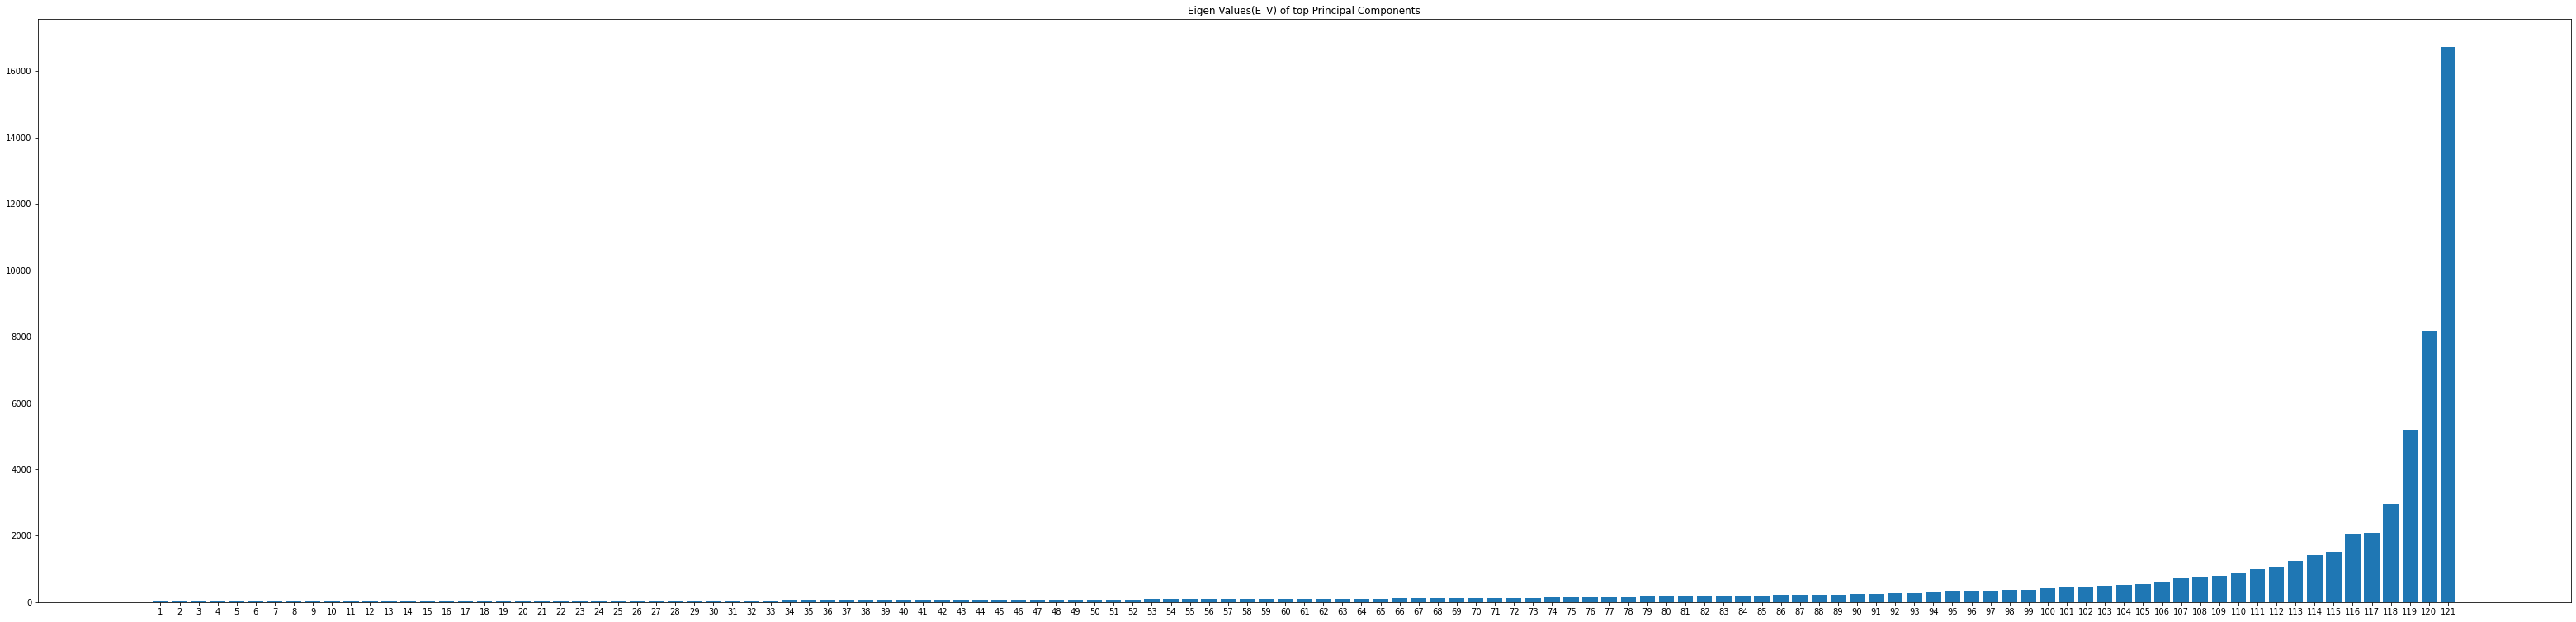

In [23]:
X = np.array(df1.drop('target', axis = 1))

PC_X = PCA(X)

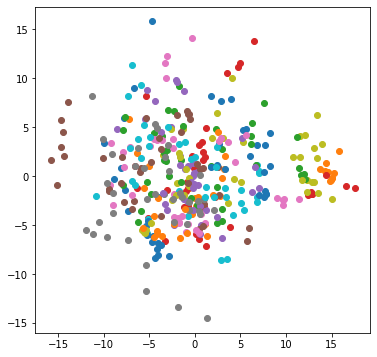

In [24]:
plt.figure(figsize= (6, 6))

for i in range(0, len(PC_X), 10):
    
    plt.scatter(PC_X[i:i+10,0], PC_X[i:i+10,1])

#plt.legend(['train' + str(i) for i in range(len(PC_X))])
plt.show()

In [25]:
test = PC_X[np.arange(0, len(PC_X)) % 10 == 0]
train = PC_X[np.arange(0, len(PC_X)) % 10 != 0]

print('\nShape of train :', train.shape, 'Shape of test :', test.shape)


Shape of train : (360, 121) Shape of test : (40, 121)


In [26]:
result = []
predicted = []

for j,samp in enumerate(test):

    distances = []

    d = np.sum((train - samp)**2, axis = 1)

    for i in range(0, len(d), 9):
        distances.append(np.sum(d[i:i+9]))
    
    result.append(np.argmin(np.stack(distances)) == j)
    predicted.append(np.argmin(np.stack(distances)))
    
    print('Test class->', j, '|', predicted[j], '<-Predicted class')

print('----------------------------------------------')
print('Accuracy :', np.sum(np.stack(result))/len(test))

Test class-> 0 | 17 <-Predicted class
Test class-> 1 | 1 <-Predicted class
Test class-> 2 | 24 <-Predicted class
Test class-> 3 | 3 <-Predicted class
Test class-> 4 | 4 <-Predicted class
Test class-> 5 | 5 <-Predicted class
Test class-> 6 | 6 <-Predicted class
Test class-> 7 | 10 <-Predicted class
Test class-> 8 | 8 <-Predicted class
Test class-> 9 | 24 <-Predicted class
Test class-> 10 | 10 <-Predicted class
Test class-> 11 | 11 <-Predicted class
Test class-> 12 | 12 <-Predicted class
Test class-> 13 | 13 <-Predicted class
Test class-> 14 | 14 <-Predicted class
Test class-> 15 | 23 <-Predicted class
Test class-> 16 | 8 <-Predicted class
Test class-> 17 | 17 <-Predicted class
Test class-> 18 | 18 <-Predicted class
Test class-> 19 | 29 <-Predicted class
Test class-> 20 | 29 <-Predicted class
Test class-> 21 | 21 <-Predicted class
Test class-> 22 | 17 <-Predicted class
Test class-> 23 | 23 <-Predicted class
Test class-> 24 | 24 <-Predicted class
Test class-> 25 | 25 <-Predicted class
Tes



---



## Question 5

In [27]:
old_feat = []
test = []

for i in range(0, len(X), 10):
    old_feat.append(X[i:i+9])
    test.append(X[i+9])

test = np.stack(test)

In [28]:
def LDA_multiclass(train, d_dash):
    
    mean = []

    for vals in train:
        mean.append(np.average(vals, axis = 0))

    mean = np.stack(mean)

    # Within class scatter matrix

    Sw = np.zeros((len(mean[0]), len(mean[0])))

    for i, vals in enumerate(train):
        for rows in vals:

            subbed = (rows - mean[i]).reshape((len(mean[i]), 1))
            dotted = np.dot(subbed, subbed.T)
            Sw += dotted    

    Sb = np.zeros((len(mean[0]), len(mean[0])))

    for i,m in enumerate(mean):
        subbed = (m - np.average(mean, axis = 0)).reshape((len(m), 1))
        Sb += len(train[i]) * np.dot(subbed, subbed.T)


    e_val, e_vec = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))

    sorted_e_val = np.flip(np.sort(e_val))
    sorted_e_vec = e_vec.copy()

    for dummy, val in enumerate(sorted_e_val):

        ind = np.argmax(e_val == val * 1)
        sorted_e_vec[:,dummy] = e_vec[:,ind]

    new_feat = np.dot(X, sorted_e_vec)


    return new_feat[:,:d_dash], sorted_e_vec


In [29]:
new_feat, transform_mat = LDA_multiclass(old_feat, 39)

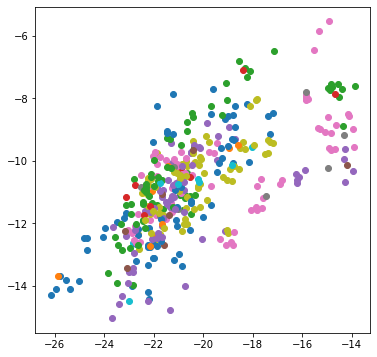

In [30]:
train = []
new_test = []

plt.figure(figsize= (6, 6))

for i,j in enumerate(range(0, len(new_feat), 10)):
    
    train.append(new_feat[j:j+9]) 
    plt.scatter(train[i][:,0], train[i][:,1])

    new_test.append(np.dot(test[i], transform_mat)[:39])
    plt.scatter(new_test[i][0], new_test[i][1])

test = np.stack(new_test)
plt.show()

In [31]:
result = []
predicted = []

for i, samp in enumerate(test):

    distances = []

    for points in train:
        d = np.sum(np.sum((points-samp)**2, axis = 1))
        distances.append(d)

    result.append(np.argmin(np.stack(distances)) == i)
    predicted.append(np.argmin(np.stack(distances)))
    
    print('Test class->', i, '|', predicted[i], '<-Predicted class')


print('----------------------------------------------')
print('Accuracy :', np.sum(np.stack(result))/len(test))


Test class-> 0 | 37 <-Predicted class
Test class-> 1 | 1 <-Predicted class
Test class-> 2 | 24 <-Predicted class
Test class-> 3 | 14 <-Predicted class
Test class-> 4 | 5 <-Predicted class
Test class-> 5 | 5 <-Predicted class
Test class-> 6 | 6 <-Predicted class
Test class-> 7 | 7 <-Predicted class
Test class-> 8 | 8 <-Predicted class
Test class-> 9 | 17 <-Predicted class
Test class-> 10 | 10 <-Predicted class
Test class-> 11 | 4 <-Predicted class
Test class-> 12 | 12 <-Predicted class
Test class-> 13 | 13 <-Predicted class
Test class-> 14 | 14 <-Predicted class
Test class-> 15 | 15 <-Predicted class
Test class-> 16 | 16 <-Predicted class
Test class-> 17 | 17 <-Predicted class
Test class-> 18 | 18 <-Predicted class
Test class-> 19 | 20 <-Predicted class
Test class-> 20 | 20 <-Predicted class
Test class-> 21 | 21 <-Predicted class
Test class-> 22 | 17 <-Predicted class
Test class-> 23 | 23 <-Predicted class
Test class-> 24 | 24 <-Predicted class
Test class-> 25 | 24 <-Predicted class
Tes